In [3]:
import numpy as np
import pandas as pd
import yaml
import torch
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch import nn
import scanpy as sc
from scvi.distributions import NegativeBinomial

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.vdm.denoising_model import MLPTimeStep
from celldreamer.models.vdm.vdm import VDM
from celldreamer.eval.optimal_transport import wasserstein

from celldreamer.models.base.utils import unsqueeze_right

device  = "cuda" if torch.cuda.is_available() else "cpu"

**Util function**

In [4]:
def init_feature_embeddings(dataset, dataset_config, device):
    feature_embeddings = {}  
    num_classes = {}
            
    for cov, cov_names in dataset.id2cov.items():
        feature_embeddings["y_"+cov] = CategoricalFeaturizer(len(cov_names), 
                                                                  dataset_config["one_hot_encode_features"], 
                                                                  device, 
                                                                  embedding_dimensions=dataset_config["cov_embedding_dimensions"])
        if dataset_config["one_hot_encode_features"]:
            num_classes["y_"+cov] = len(cov_names)
        else:
            num_classes["y_"+cov] = dataset_config["cov_embedding_dimensions"]
    return feature_embeddings

**Cofigurations**

In [6]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/celldreamer_trained/f841f70b-2b9a-471b-a47f-42cdd47d2064/checkpoints/last.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]

In [7]:
dataset_config = {'dataset_path': '../../datasets/processed/dentategyrus.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['clusters'],
                    'sampling_covariate': 'clusters',
                    'subsample_frac': 1,
                    'encoder_type': 'learnt',
                    'target_max': 1,
                    'target_min': -1,
                    'n_dimensions': None,
                    'one_hot_encode_features': True,
                    'split_rates': [0.90, 0.05, 0.05],
                    'cov_embedding_dimensions': None}

generative_model_config = {'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'noise_schedule': 'learnt_linear',
                            'gamma_min': -4.,
                            'gamma_max': 4.,
                            'antithetic_time_sampling': False,
                            'scaling_method': 'log_normalization',
                            'x0_from_x_kwargs': {
                                'dims': [512, 512],
                                'batch_norm': False,
                                'dropout': False,
                                'dropout_p': 0.0
                            },
                            'pretrain_encoder': True,
                            'pretraining_encoder_epochs': 150,
                            'use_tanh_encoder': False}

**Initialization**

Initialize dataset 

In [8]:
data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                                layer_key=dataset_config["layer_key"],
                                covariate_keys=dataset_config["covariate_keys"],
                                subsample_frac=dataset_config["subsample_frac"], 
                                encoder_type=dataset_config["encoder_type"],
                                target_max=dataset_config["target_max"], 
                                target_min=dataset_config["target_min"])

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


Initialize feature embeddings

In [9]:
feature_embeddings = init_feature_embeddings(dataset, dataset_config, device)

Initialize VDM 

In [10]:
generative_model = VDM(
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=in_dim,
            size_factor_statistics=size_factor_statistics,
            scaler=None,
            encoder_type=dataset_config["encoder_type"],
            sampling_covariate=dataset_config["sampling_covariate"],
            model_type=denoising_model.model_type, 
            **generative_model_config  # model_kwargs should contain the rest of the arguments
        )

generative_model.load_state_dict(ckpt["state_dict"])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


<All keys matched successfully>

In [11]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [12]:
Z_enc = []
X_real = []
X_generated = []

with torch.no_grad():
    for batch in dataloader:
        X = batch["X"]
        l = X.sum(1).unsqueeze(1)
        X_scaled = generative_model._scale_batch(X)
        Z = generative_model.x0_from_x(X_scaled)
        Z_enc.append(Z)
        X_real.append(batch["X"].cpu())
        # Generate 
        distr = NegativeBinomial(mu=torch.softmax(Z, 1)*l, theta=torch.exp(generative_model.theta))
        X_sample = distr.sample()
        X_generated.append(X_sample.cpu())

Z_enc = torch.cat(Z_enc, dim=0)
X_real = torch.cat(X_real, dim=0)
X_generated = torch.cat(X_generated, dim=0)

adata_z = sc.AnnData(X=Z_enc.numpy())

obs = pd.DataFrame(["real" for _ in range(len(X_real))]+["generated" for _ in range(len(X_generated))])
obs.columns = ["dataset_type"]
adata = sc.AnnData(torch.cat([X_real, X_generated], dim=0).numpy(),
                  obs=obs)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [13]:
sc.tl.pca(adata_z)
sc.pp.neighbors(adata_z)
sc.tl.umap(adata_z)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


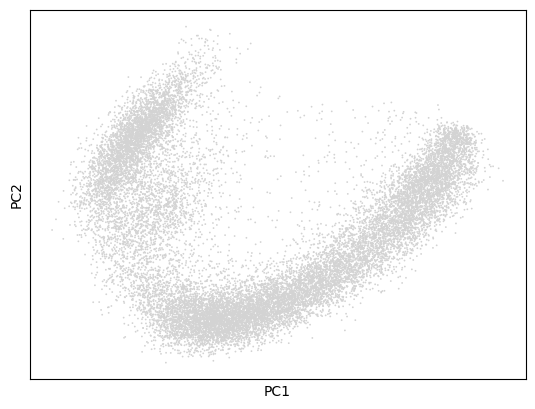

In [14]:
sc.pl.pca(adata_z)

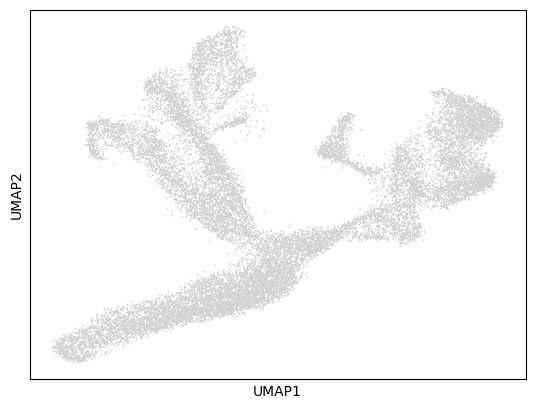

In [15]:
sc.pl.umap(adata_z)

In [16]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


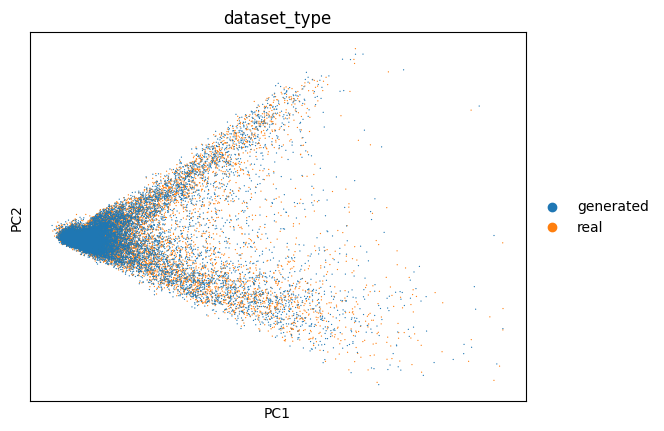

In [17]:
sc.pl.pca(adata, color="dataset_type")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


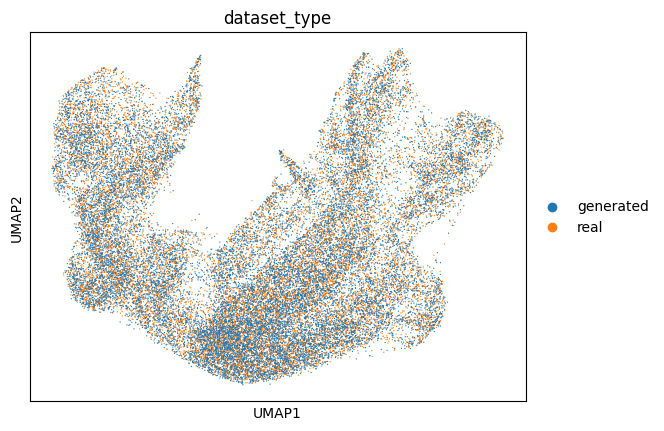

In [18]:
sc.pl.umap(adata, color="dataset_type")

In [19]:
Z_enc

tensor([[-14.7227,  -1.9845,  -2.3109,  ...,  -1.2589,   4.1193,   4.1684],
        [-10.8860,   3.4132,  -6.1145,  ...,   2.3139,   0.2893,   3.2269],
        [-12.0757,   0.7836,   0.0457,  ...,  -0.3223,   0.7529,   3.2897],
        ...,
        [-14.5217,  -1.7517,  -5.0398,  ...,   4.3809,   3.4083,   5.3377],
        [ -4.8987,  -5.8649,  -7.7709,  ...,  -0.9842,  -0.1683,   2.1953],
        [-11.7181,  -8.1016,  -0.7288,  ...,   0.1045,  -0.4986,   2.5860]])

(array([  2.,   4.,  25.,  77., 182., 206., 362., 574., 474.,  94.]),
 array([-23.43754959, -20.29894257, -17.16033554, -14.02172947,
        -10.88312244,  -7.74451637,  -4.60590935,  -1.4673028 ,
          1.67130399,   4.80991077,   7.94851732]),
 <BarContainer object of 10 artists>)

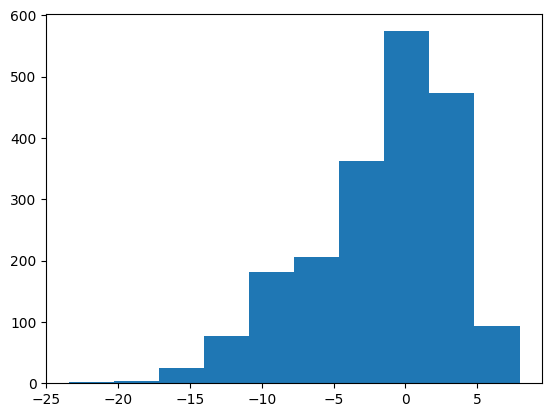

In [21]:
plt.hist(Z_enc[0])